
## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.


<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [3]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  
a. Read in the dataset and take a look at the top few rows here:

In [4]:
#import data
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [5]:
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [6]:
df.nunique()

user_id         290584
timestamp       294478
group                2
landing_page         2
converted            2
dtype: int64

d. The proportion of users converted.

In [7]:
df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [8]:
df_not_tre = len(df.query('group != "treatment" & landing_page == "new_page"'))

In [9]:
df_tre = len(df.query('group == "treatment" & landing_page != "new_page"'))

In [10]:
print(df_not_tre + df_tre)

3893


f. Do any of the rows have missing values?

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [12]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page. 

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [13]:
# put treatment & new_page into one dataframe
df2t = df.query('group == "treatment" and landing_page == "new_page"')

In [14]:
# put  control & old_page into one dataframe
df2c = df.query('group == "control" and landing_page == "old_page"')

In [15]:
df2 = df2t.merge(df2c, how="outer")

In [16]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

In [17]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
1,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
2,679687,2017-01-19 03:26:46.940749,treatment,new_page,1
3,817355,2017-01-04 17:58:08.979471,treatment,new_page,1
4,839785,2017-01-15 18:11:06.610965,treatment,new_page,1


a. How many unique **user_id**s are in **df2**?

In [18]:
df2.user_id.nunique()

290584

In [19]:
df2.nunique()

user_id         290584
timestamp       290585
group                2
landing_page         2
converted            2
dtype: int64

b. There is one **user_id** repeated in **df2**.  What is it?

In [20]:
df2.user_id.duplicated().sum()

1

c. What is the row information for the repeat **user_id**? 

In [21]:
df2.loc[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
1404,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [22]:
df2 = df2.drop_duplicates(subset = 'user_id', keep = 'first')

In [23]:
df2.user_id.duplicated().sum()

0

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [24]:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [25]:
df2_control = df2.query('group == "control"')
df2_control.converted.mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [26]:
df2_treatment = df2.query('group == "treatment"')
df2_treatment.converted.mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [27]:
len(df2_treatment.index)/len(df2.index)

0.5000619442226688

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

#### Probability of individual converting given individual is in control group is (0.12) and probability of individual converting given individual is in treatment group is(0.1188).
#### According to the analysis this is clear that there is no more conversion between new page and old page so the converting rate is similar in both cases and it is important to take other factors.


<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

#### If we assume the old page is better unless the new page proves to be definately better, then the null hypotheses is that the mean converted rate of the old page is greater or equal to the converted rate of the new page and the alternative hypothesis is that the mean converted rate of the old page is less than the converted rate of the new page.
####  Null hypotheses : **$p_{old}$** >= **$p_{new}$**
#### Alternative hypotheses : **$p_{old}$** < **$p_{new}$**

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [28]:
p_new = df2.converted.mean()
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [29]:
p_old = df2.converted.mean()
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [30]:
n_new = len(df2_treatment.index)
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [31]:
n_old = len(df2_control.index)
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [32]:
## simulate n_old transactions with a convert rate of p_new under the null
new_page_converted = np.random.choice([0, 1], n_new, p = [p_new, 1-p_new])

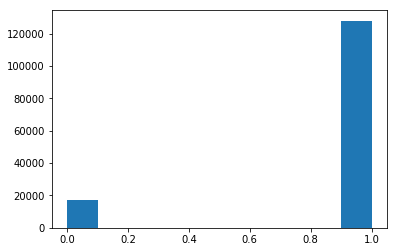

In [33]:
# check new_page_converted values:
plt.hist(new_page_converted);

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [34]:
# simulate n_old transactions with a convert rate of p_old under the null
old_page_converted = np.random.choice([0, 1], n_old, p = [p_old, 1-p_old])

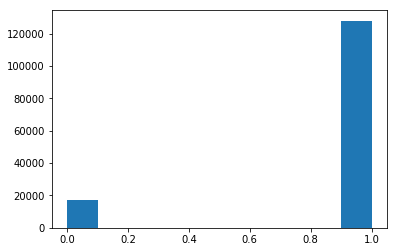

In [35]:
# check old_page_converted values:
plt.hist(old_page_converted);

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [36]:
# differences computed in from p_new and p_old
obs_diff= df2_treatment.converted.mean()-df2_control.converted.mean()
obs_diff

-0.0015782389853555567

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [37]:
# run simulation 10000 times
p_diffs = []
for i in range(10000):
    
    # 1st parameter dictates the choices you want.  In this case [1, 0]
    p_new1 = np.random.choice([1, 0],n_new,replace = True,p = [p_new, 1-p_new])
    p_old1 = np.random.choice([1, 0],n_old,replace = True,p = [p_old, 1-p_old])
    p_new2 = p_new1.mean()
    p_old2 = p_old1.mean()
    p_diffs.append(p_new2-p_old2)
p_diffs = np.array(p_diffs)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

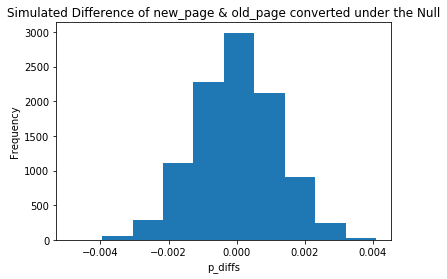

In [38]:
# plot sampling distribution
plt.hist(p_diffs)
plt.xlabel('p_diffs')
plt.ylabel('Frequency')
plt.title('Simulated Difference of new_page & old_page converted under the Null');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

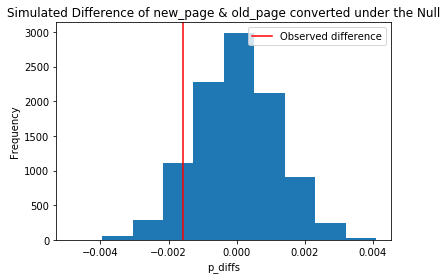

In [39]:
# plot line for observed statistic
plt.hist(p_diffs)
plt.axvline(x=obs_diff, color='r', label="Observed difference")
plt.xlabel('p_diffs')
plt.ylabel('Frequency')
plt.title('Simulated Difference of new_page & old_page converted under the Null');
plt.legend()
plt.show()

In [40]:
#calculate the proportion of p_diffs greater than the observe difference
p_val=(np.array(p_diffs) > obs_diff).mean()
print(p_val)

0.9059


k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

#### the proportion of the p_diffs that are greater than the actual difference observed in ab_data.csv. In scientific studies this value is also called p-value. This value means that we cannot reject the null hypothesis and that we do not have sufficient evidence that the new_page has a higher conversion rate than the old_page.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [41]:
import statsmodels.api as sm

convert_old = len(df2_control[df2_control['converted'] == 1])
convert_new = len(df2_treatment[df2_treatment['converted'] == 1])
n_old = len(df2_control.index)
n_new = len(df2_treatment.index)

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [42]:
convert_old , convert_new

(17489, 17264)

In [43]:
n_old , n_new 

(145274, 145310)

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [44]:
#Computing z_score and p_value
z_score, p_value = sm.stats.proportions_ztest([convert_old,convert_new], [n_old, n_new],alternative='smaller') 

#display z_score and p_value
print(z_score,p_value)

1.31092419842 0.905058312759


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

#### The z-score and the p_value mean that one doesn't reject the Null. The Null being the converted rate of the old_page is the same or greater than the converted rate of the new_page. The p_value is 0.91 and is higher than 0.05 significance level. That means we can not be confident with a 95% confidence level that the converted rate of the new_page is larger than the old_page.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

#### The dependent variable is a binary variable (converted vs not converted). Thus, you need to use a logistic regression.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [45]:
#adding an intercept column
df2['intercept'] = 1
#Create dummy variable column
df2['ab_page'] = pd.get_dummies(df2['group'])['treatment']
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
1,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
2,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1
3,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1
4,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [46]:
lm = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results=lm.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [47]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-11-30 11:45 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

**The p-value associated with ab_page is 0.19**

In Part II, the p-value was calculated where the null hypothesis was that the new page would convert more than the old page, and the alternative was the old page converted more than or equal to the new page.

In Part III, we used variables, and used a linear model to determine the p-value. The null hypothesis was that the difference between the pages is equal to 0, and the alternative hypothesis was the difference between the pages is greater or less than 0.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

#### It would be a good idea to consider other factors to add into the regression model. Perhaps time of day that the user used the page, might influence when people sign up online. The disadvantage is it adds complexity, because variables may affect other variables. Also, some variables may not affect the outcome.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [48]:
# Store Countries.csv data in dataframe
df_countries = pd.read_csv('countries.csv')
df_countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [49]:
df_countries.country.unique()

array(['UK', 'US', 'CA'], dtype=object)

In [50]:
country_dummies = pd.get_dummies(df_countries['country'])
df_new = df_countries.join(country_dummies)
df_new.head()

,user_id,country,CA,UK,US
0,834778,UK,0,1,0
1,928468,US,0,0,1
2,822059,UK,0,1,0
3,711597,UK,0,1,0
4,710616,UK,0,1,0


In [51]:
df3 = df2.set_index('user_id').join(df_new.set_index('user_id'))
df3.head()

,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US
user_id,,,,,,,,,,
661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1
853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1
679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,CA,1,0,0
817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,UK,0,1,0
839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,CA,1,0,0


In [52]:
#Set Canada as baseline country
lm = sm.Logit(df3['converted'], df3[['intercept', 'UK', 'US']])
results = lm.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-11-30 11:45 AIC:              212780.8333
No. Observations:   290584           BIC:              212812.5723
Df Model:           2                Log-Likelihood:   -1.0639e+05
Df Residuals:       290581           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0375    0.0260  -78.3639  0.0000  -2.0885  -1.9866
UK             0.0507    0.0284    1.7863  0.0740  -0.0049   0.1064
US             0.0408    0.0269    1.5178  0.1291  -0.0119   0.0935
==================================================================

"""

### The correlation coefficient is very small for both UK and US. This means the relationship between country and conversion is weak.

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [53]:
df3['US_page'] = df3['US'] * df3['ab_page']
df3['UK_page'] = df3['UK'] * df3['ab_page']
df3.head()

,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US,US_page,UK_page
user_id,,,,,,,,,,,,
661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1,1,0
853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1,1,0
679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,CA,1,0,0,0,0
817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,UK,0,1,0,0,1
839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,CA,1,0,0,0,0


In [54]:
lm = sm.Logit(df3['converted'], df3[['intercept', 'ab_page', 'UK', 'US','UK_page','US_page']])
results = lm.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-11-30 11:45 AIC:              212782.6602
No. Observations:   290584           BIC:              212846.1381
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290578           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0040    0.0364  -55.0077  0.0000  -2.0754  -1.9326
ab_page       -0.0674    0.0520   -1.2967  0.1947  -0.1694   0.0345
UK             0.0118    0.0398    0.2957  0.7674  -0.0663   0.0899
US             0.0175    0.0377    0.4652  0.6418  -0.0563   0.0914
UK_page        0.0783    0.0568    1.3783  0.1681  -0.0330   0.1896
US_page        0.0469    0.0538    0.8718  0.3833  -0.0585   0.1523
==================================================================

"""

#### The p-value for ab_page is 0.19.
#### The p-value is still large. We fail to reject the null hypothesis.



#### Conclusions: None of the variables have significant p-values. Therefore, we will fail to reject the null and conclude that there is not sufficient evidence to suggest that there is an interaction between country and page received that will predict whether a user converts or not.

#### Now we can say that we do not have sufficient evidence to suggest that the new page results in more conversions than the old page.

In [55]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0